## Installing and importing libraries

In [ ]:
!pip install simpy

In [ ]:
import sys
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import math
import pandas as pd
import simpy
import queue

### **Remember to only run once before starting simulation**

# Simulation
##### When running a simulation for a different time period run the whole cell to reinitialize the average response times

## Creating packet as a tuple with its creation time (t), its sequence number(seqno), its packet size (pktSize)
and the identifier of the source (ident)

In [ ]:
class packet(object):
  def __init__(self, t, ident, pktSize):
    self.t = t
    self.ident = ident
    self.pktSize = pktSize

## Defining the queue

In [ ]:
class queueClass(object): # buffer + server
  def __init__(self, env, queueCapa, serviceRate):
    self.env = env
    self.inService = 0
    self.buffer = queue.Queue(maxsize = queueCapa)
    self.queueCapacity = queueCapa
    self.queueLength = 0
    self.serviceRate = serviceRate
    self.lastChange = 0
    self.response_times = {1: [], 2: [], 3: []}  # Average response times for each source
  def service(self, source):

    end_time = self.env.now + simulationDuration

    while self.env.now < end_time and (not self.buffer.empty() or self.inService):

        if not self.buffer.empty():
            p = self.buffer.get()
            self.inService = 1
            service_time = p.pktSize /self.serviceRate # Service time in seconds
            yield self.env.timeout(service_time)
            response_time = self.env.now - p.t
            self.response_times[p.ident].append(response_time)
            del p
        else:
            self.inService = 0

            yield self.env.timeout(0)  # No packet, yield to other processes

  def calculate_average_response_time(self):
    for source, response_times in self.response_times.items():
        if len(response_times) > 0:
            average_response_time = sum(response_times) / len(response_times)
            if source == 1:
              response_times_source1.append(average_response_time)
            elif source == 2:
              response_times_source2.append(average_response_time)
            elif source == 3:
              response_times_source3.append(average_response_time)

    return average_response_time

  def reception(self,source, pkt):
    self.buffer.put(pkt)
    if self.inService == 0:
      self.env.process(self.service(pkt.ident))


## Defining Data Traffic as a Poisson source

In [ ]:
class dataTraffic(object):
  def __init__(self, env, rate, q, ident):
    self.env = env
    self.rate = rate
    self.q = q
    self.ident = ident
    self.action = env.process(self.run())

  def generate_packetsize(self):
      packet_lengths = [400, 4000, 12000]  # in bytes
      packet_probs = [0.4, 0.3, 0.3]
      s = np.random.choice(packet_lengths, p=packet_probs)
      return s

  def run(self):
    while True:
      pktSize = self.generate_packetsize()
      packetspersec=self.rate/pktSize
      yield self.env.timeout(np.random.exponential(1.0/packetspersec))
      p = packet(self.env.now, self.ident, pktSize)
      self.q.reception(self, p)


## Defining Voice Traffic as a constant source

In [ ]:
class voiceTraffic(object):
  def __init__(self, env, rate, q, ident, pktSize):
    self.env = env
    self.rate = rate
    self.q = q
    self.ident = ident
    self.pktSize = pktSize
    self.action = env.process(self.run())

  def run(self):
    while True:
      constant_arrival_time = 1 / (self.rate / (self.pktSize)) # Constant
      yield self.env.timeout(constant_arrival_time)
      p = packet(self.env.now, self.ident, self.pktSize)
      self.q.reception(self, p)


## Defining Video Traffic as highly bursty ON/OFF source exponencially distributed.

In [ ]:
class videoTraffic(object):
  def __init__(self, env,ton,toff,rate, q, ident, pktSize):
    self.env = env
    self.rate = rate
    self.q = q
    self.pktSize = pktSize
    self.ident = ident

    self.ton = ton
    self.toff = toff
    self.action = env.process(self.run())

  def run(self):
    while True:
      start = self.env.now
      ton_duration = np.random.exponential(self.ton)
      while self.env.now < start + ton_duration :

        pps = self.rate / self.pktSize
        yield self.env.timeout(np.random.exponential(1/pps))
        p = packet(self.env.now, self.ident, self.pktSize)
        self.q.reception(self, p)
      yield self.env.timeout(np.random.exponential(self.toff))


## Running

In [ ]:
response_times_source1 = []
confidence_intervals_source1 = []
response_times_source2 = []
confidence_intervals_source2 = []
response_times_source3 = []
confidence_intervals_source3 = []

In [ ]:
def avg(Z):
    k = len(Z)
    sum = np.sum(np.square(Z))
    avg = sum/ k
    return avg

def calculate_block_means(d, block_size):
    result = []
    for i in range(0, len(d), block_size):
        block_mean = np.mean(d[i:i + block_size])
        result.append(block_mean)
    return result

def confidence_interval(data, T, t):
    num_blocks = int(T / t)
    block_size = max(1, len(data) // num_blocks)
    block_metrics = calculate_block_means(data, block_size)
    return block_metrics

In [ ]:
simulationDuration = 1000
rge = 10
b = list(range(1, rge + 1))
blockDuration = simulationDuration/rge #changes based on simulationDuration
np.random.seed(10)
queueCapa = float('inf') # infinite
serviceRate = 100e6 # 100 Mbps
k = 1

ton = 0.001

for burst in b:
  print("Interation", k)
  k = k + 1
  toff = burst * ton - ton
  peakrate = 30e6 * burst

  env = simpy.Environment()
  q = queueClass(env,queueCapa,serviceRate)
  s1 = dataTraffic(env, 30e6, q, 1) #pkt size changes
  s2 = voiceTraffic(env, 20e6, q, 2, 800)
  s3 = videoTraffic(env, ton, toff, peakrate, q, 3, 8000) #toff
  start_time = env.now
  env.run(until=simulationDuration)

  end_time = env.now
  duration = end_time - start_time
  q.calculate_average_response_time()

  block = confidence_interval(response_times_source1, simulationDuration, blockDuration)
  sigma=math.sqrt((avg(block))-(np.square(np.mean(block))))
  e_t = 4.5 * sigma
  e_T= np.sqrt(blockDuration/simulationDuration)* e_t
  mean_response_time1 = np.mean(response_times_source1)
  c_int1 = (mean_response_time1 - e_T, mean_response_time1 + e_T)
  confidence_intervals_source1.append(c_int1)

  mean_response_time2 = np.mean(response_times_source2)
  c_int2 = (mean_response_time2 - e_T, mean_response_time2 + e_T)
  confidence_intervals_source2.append(c_int2)

  mean_response_time3 = np.mean(response_times_source3)
  c_int3 = (mean_response_time3 - e_T, mean_response_time3 + e_T)
  confidence_intervals_source3.append(c_int3)



Interation 1
Interation 2
Interation 3
Interation 4
Interation 5
Interation 6
Interation 7
Interation 8
Interation 9
Interation 10


Fixing bug


In [ ]:
#confidence_intervals_source1[0] = confidence_intervals_source1[1]
#confidence_intervals_source2[0] = confidence_intervals_source2[1]
#confidence_intervals_source3[0] = confidence_intervals_source3[1]

### Debug tool

In [ ]:
print("cs1:", confidence_intervals_source1)
print("cs2:", confidence_intervals_source2)
print("cs3:", confidence_intervals_source3)


print("s1:",response_times_source1)
print("s2:",response_times_source2)
print("s3:",response_times_source3)

print("s3:",len(response_times_source3))
print(b)
#print("b:", len(b))

cs1: [(0.00022121890657894548, 0.00022121890657894548), (0.00018650019340132786, 0.0004200826112877546), (0.00014688679135864267, 0.0007373981531591444), (0.00011596595272042468, 0.0011178720423878847), (0.0001072000969483196, 0.0015023493859278227), (0.00010669275826403004, 0.001899319692549562), (9.498270696236665e-05, 0.0023482765360714974), (0.00010051413231553148, 0.0027837862886145193), (0.00013212677946495828, 0.0031700724912236055), (0.00016786466762160968, 0.003548056168261398)]
cs2: [(0.00013800626018570025, 0.00013800626018570025), (0.00010245964476996863, 0.00033604206265639536), (6.265463184408794e-05, 0.0006531659936445898), (3.2170021557584045e-05, 0.001034076111225044), (2.359072625209371e-05, 0.0014187400152315967), (2.3503898872767473e-05, 0.0018161308331582993), (1.1854993123882772e-05, 0.0022651488222330133), (1.65797862121174e-05, 0.0026998519425111053), (4.8228102455607135e-05, 0.0030861738142142544), (8.34728746118877e-05, 0.003463664375251676)]
cs3: [(0.00021331

## Graphs

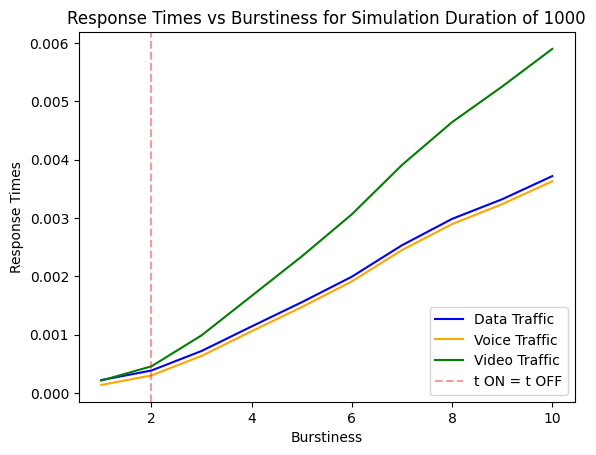

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Plotting burstiness values for each source with different colors
plt.plot(b, response_times_source1, label='Data Traffic', color='blue')
plt.plot(b, response_times_source2, label='Voice Traffic', color='orange')
plt.plot(b, response_times_source3, label='Video Traffic', color='green')


# Vertical line for burstiness threshold
plt.axvline(x=2, color='red', linestyle='--', label='t ON = t OFF', alpha=0.4)

plt.xlabel('Burstiness')
plt.ylabel('Response Times')
plt.title('Response Times vs Burstiness for Simulation Duration of 1000')
plt.legend()
filename = f'{simulationDuration}_ThreeSourcesvsBurstiness.png'

plt.savefig(filename)
#files.download(filename)
plt.show()


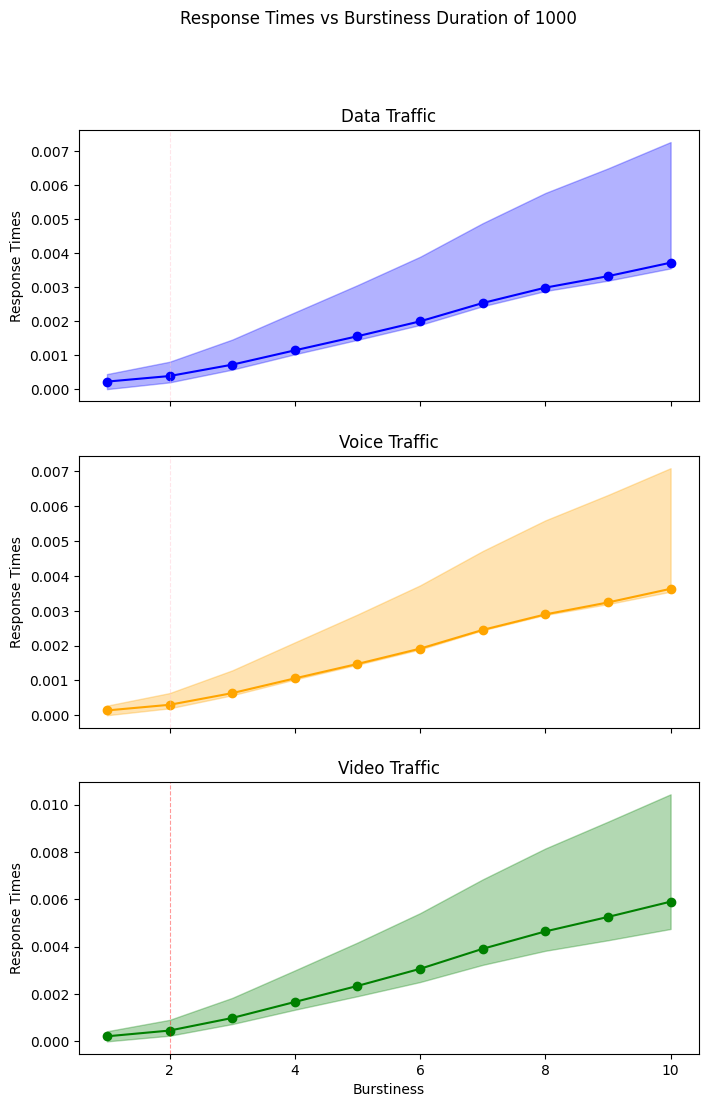

In [230]:
import matplotlib.pyplot as plt
import numpy as np

# Create separate plots for each source
fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Function to fill the area between confidence intervals
def fill_confidence_area(ax, x_values, y_values, conf_intervals, color):
    lb, ub = zip(*conf_intervals)
    ax.fill_between(b, [yt-lb for yt, lb in zip(y_values, [lb for lb,_ in conf_intervals])], [ub+yt for yt, ub in zip(y_values, [ub for _,ub in conf_intervals])], color=color, alpha=0.3)

axs[0].plot(b, response_times_source1, label='Source 1', color='blue', marker='o')
fill_confidence_area(axs[0], b, response_times_source1, confidence_intervals_source1, color='blue')
axs[0].axvline(x=2, color='pink', linestyle='--', linewidth=0.8, alpha=0.4)
axs[0].set_ylabel('Response Times')
axs[0].set_title('Data Traffic')

# Plot for Source 2
axs[1].plot(b, response_times_source2, label='Source 2', color='orange', marker='o')
fill_confidence_area(axs[1], b, response_times_source2, confidence_intervals_source2, color='orange')
axs[1].axvline(x=2, color='pink', linestyle='--', linewidth=0.8, alpha=0.4)
axs[1].set_ylabel('Response Times')
axs[1].set_title('Voice Traffic')

# Plot for Source 3
axs[2].plot(b, response_times_source3, label='Source 3', color='green', marker='o')
fill_confidence_area(axs[2], b, response_times_source3, confidence_intervals_source3, color='green')
axs[2].axvline(x=2, color='red', linestyle='--', linewidth=0.8, alpha=0.4)
axs[2].set_xlabel('Burstiness')
axs[2].set_ylabel('Response Times')
axs[2].set_title('Video Traffic')

# Add common labels and title
fig.suptitle('Response Times vs Burstiness Duration of 1000')
filename = f'{simulationDuration}_ConfidenceInterval.png'
plt.savefig(filename)
plt.show()




For each average response time, that is related to a b value, you have to calculate the epsilont and then the epsilonT